In [174]:
import random
import numpy as np 
import random
import matplotlib.pyplot as plt
import time 
from collections import deque  
import pulp   
import networkx as nx   

In [175]:
# Générer le graphe TSP incomplet
def generate_tsp_incomplete(num_sommets, max_poids_arete):
    matrice = [[None for _ in range(num_sommets)] for _ in range(num_sommets)]
    intervalles = {} 
    for i in range(num_sommets):
        intervalle_start = random.randint(0, 10)
        intervalle_end = intervalle_start + random.randint(5, 100)
        intervalles[i] = (intervalle_start, intervalle_end)
    for i in range(num_sommets):
        for j in range(i + 1, num_sommets):
            if random.choice([True, False]):
                poids = random.randint(1, max_poids_arete)
                matrice[i][j] = poids
                matrice[j][i] = poids
    for i in range(num_sommets):
        pas_connexe = True
        for j in range(num_sommets):
            if matrice[i][j] is None:
                matrice[i][j] = float('inf')
            else:
                pas_connexe = False
        if pas_connexe:
            poids = random.randint(1, max_poids_arete)
            if i != (num_sommets-1):
                matrice[i][num_sommets-1] = poids
                matrice[num_sommets-1][i] = poids
            else:
                matrice[i][num_sommets-2] = poids
                matrice[num_sommets-2][i] = poids
    return np.array(matrice), intervalles 

In [176]:
num_sommets = 5
max_poids_arete = 10

# Générer les données du problème
tsp_matrice, tsp_intervalles = generate_tsp_incomplete(num_sommets, max_poids_arete)

# Afficher la matrice pondérée
print("\nMatrice pondérée:")
for row in tsp_matrice:
    print(row) 

# Afficher les intervalles
print("\nIntervalles des sommets")
print(tsp_intervalles) 


Matrice pondérée:
[inf  8. 10. inf  8.]
[ 8. inf  6. inf inf]
[10.  6. inf inf  6.]
[inf inf inf inf  6.]
[ 8. inf  6.  6. inf]

Intervalles des sommets
{0: (9, 50), 1: (3, 65), 2: (2, 70), 3: (9, 39), 4: (10, 109)}


In [177]:
# Paramètres de la colonie de fourmis
num_ants = 10
num_iterations = 100
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_constant = 100 

In [178]:
def is_edge_valid(from_node, to_node, current_length, visited):
    weight = tsp_matrice[from_node][to_node]
    if weight == np.inf:
        return (False, 0)
    if to_node in visited:
        min_weight, max_weight = tsp_intervalles[to_node]
        if current_length + weight > max_weight:
            return (False, 0)
        if current_length + weight < min_weight:
            return (True,  min_weight - current_length)
    return (True, weight) 

In [179]:

def update_pheromones(best_path, best_path_length, pheromone_tsp_matrice):
    pheromone_tsp_matrice *= (1 - evaporation_rate)
    for i in range(len(best_path) - 1):
        from_node = best_path[i]
        to_node = best_path[i + 1]
        pheromone_tsp_matrice[from_node][to_node] += pheromone_constant / best_path_length 

In [180]:
def select_next_node(current_node, visited, current_length, pheromone_tsp_matrice):
    probabilities = []
    total_prob = 0
    pheromone_row = pheromone_tsp_matrice[current_node]
    heuristic_row = (1.0 / tsp_matrice[current_node]) ** beta

    for node in range(num_sommets):
        if node != current_node:
            valide, poids = is_edge_valid(current_node, node, current_length, visited)
            if valide:
                pheromone_level = pheromone_row[node] ** alpha
                heuristic_level = heuristic_row[node]
                probability = pheromone_level * heuristic_level
                probabilities.append((node, probability))
                total_prob += probability
    
    if total_prob == 0:
        return (None, 0)
    
    threshold = random.uniform(0, total_prob)
    cumulative_prob = 0
    for node, probability in probabilities:
        cumulative_prob += probability
        if cumulative_prob >= threshold:
            valide, poids = is_edge_valid(current_node, node, current_length, visited)
            return (node, poids)
    return (None, 0) 


In [181]:
def ant_colony_optimization():
    best_path = None
    best_path_length = float('inf') 
    path_lengths = deque(())
    best_path_lengths = deque(())
    execution_times = [] 
    distances = [] 
    # Initialiser les niveaux de phéromones uniquement sur les arêtes
    pheromone_tsp_matrice = np.ones((num_sommets, num_sommets))

    for iteration in range(num_iterations):
        start_time = time.time() 
        all_paths = []
        for ant in range(num_ants):
            current_node = random.randint(0, num_sommets - 1)
            path = [current_node]
            visited = {current_node}
            min_weight, max_weight = tsp_intervalles[current_node]
            current_length = min_weight
            
            # Construire un chemin
            while len(visited) < num_sommets:
                next_node, weight_to_add = select_next_node(current_node, visited, current_length, pheromone_tsp_matrice)
                if next_node is None:
                    break
                current_length += weight_to_add
                current_node = next_node
                path.append(current_node)
                visited.add(current_node)
            
            # Vérifier si un cycle est formé
            valid, weight = is_edge_valid(current_node, path[0], current_length, visited)
            if len(visited) == num_sommets and valid:
                current_length += weight
                path_lengths.append(current_length)
                path.append(path[0]) 
                all_paths.append((path, current_length))
                if current_length < best_path_length:
                    best_path_length = current_length
                    best_path = path
                best_path_lengths.append(best_path_length)    
            
            
        # Mettre à jour les phéromones uniquement sur le meilleur chemin trouvé
        if best_path:
            update_pheromones(best_path, best_path_length, pheromone_tsp_matrice)
        end_time = time.time()
        execution_times.append(end_time - start_time)
        distances.append(best_path_length) 
    
    return best_path, best_path_length, path_lengths, best_path_lengths , execution_times, distances   

In [182]:
def borne_inferieure(tsp_matrice):
    # Nombre de villes
    num_cities = tsp_matrice.shape[0]

    # Création du problème de minimisation
    prob = pulp.LpProblem("tsp", pulp.LpMinimize)

    # Variables de décision
    x = pulp.LpVariable.dicts("x", ((i, j) for i in range(num_cities) for j in range(num_cities)), cat='Binary')

    # Fonction objectif : minimiser la distance totale
    prob += pulp.lpSum(tsp_matrice[i][j] * x[i, j] for i in range(num_cities) for j in range(num_cities) if tsp_matrice[i][j] != np.inf)

    # Contraintes
    for i in range(num_cities):
        # Chaque ville doit être quittée au moins une fois sup ou egale 1 
        prob += pulp.lpSum(x[i, j] for j in range(num_cities) if i != j and tsp_matrice[i][j] != np.inf) == 1
        # Chaque ville doit être entrée au moins une fois
        prob += pulp.lpSum(x[j, i] for j in range(num_cities) if i != j and tsp_matrice[j][i] != np.inf) == 1

    # Elimination des sous-tours
    u = pulp.LpVariable.dicts("u", (i for i in range(num_cities)), lowBound=0, upBound=num_cities-1, cat='Continuous')

    for i in range(1, num_cities):
        for j in range(1, num_cities):
            if i != j and tsp_matrice[i][j] != np.inf:
                prob += u[i] - u[j] + (num_cities - 1) * x[i, j] <= num_cities - 2

    # Résolution du problème
    prob.solve()

    if pulp.LpStatus[prob.status] == "Optimal":
        solution = [(i, j) for i in range(num_cities) for j in range(num_cities) if pulp.value(x[i, j]) == 1]
        return pulp.value(prob.objective), solution
    else:
        return None, None 


In [183]:
def plot_route(path, points, matrice):
    plt.figure(figsize=(10, 5))
    plt.scatter(points[:, 0], points[:, 1], c='blue')

    # Highlight the start node
    start_node = path[0]
    plt.scatter(points[start_node, 0], points[start_node, 1], c='red', label='Start Node')

    # Annotate nodes with their indices
    for idx, point in enumerate(points):
        plt.text(point[0], point[1], str(idx), fontsize=12, ha='right', va='bottom')

    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        plt.plot([points[from_node, 0], points[to_node, 0]], 
                 [points[from_node, 1], points[to_node, 1]], 'k-')
        # Add weights (distances) on the edges
        mid_point = (points[from_node] + points[to_node]) / 2
        weight = matrice[from_node][to_node]
        plt.text(mid_point[0] + 2, mid_point[1] + 2, f'{weight:.2f}', fontsize=9, color='green')

    # Add the weight for the edge returning to the start node
    from_node = path[-1]
    to_node = path[0]
    plt.plot([points[from_node, 0], points[to_node, 0]], 
             [points[from_node, 1], points[to_node, 1]], 'k-')
    mid_point = (points[from_node] + points[to_node]) / 2
    weight = matrice[from_node][to_node]
    plt.text(mid_point[0] + 2, mid_point[1] + 2, f'{weight:.2f}', fontsize=9, color='green')

    plt.title('Best Route Found')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show() 

In [184]:
def plot_routeLinear(solution, points):
    if solution:
        route = np.array([points[i] for i, j in solution] + [points[solution[0][0]]])
        plt.figure(figsize=(10, 6))
        plt.plot(route[:, 0], route[:, 1], 'o-', label='Route')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('TSP Route')
        plt.legend()
        plt.show()
    else:
        print("No solution to plot.")  

In [185]:
def plot_performance(execution_times, distances):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Execution Time (s)', color=color)
    ax1.plot(execution_times, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Best Path Length', color=color)  
    ax2.plot(distances, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()   
    plt.title('Performance Over Iterations')
    plt.show() 

In [186]:
def plot_quality(best_path_lengths):
    plt.figure(figsize=(10, 5))
    plt.plot(best_path_lengths, marker='o', linestyle='-', color='b')
    plt.title('ACO Performance: Best Path Length Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Best Path Length')
    plt.grid(True)
    plt.show()


In [187]:
def plot_vi(path_lengths, best_path_lengths):
    plt.figure(figsize=(10, 5))
    plt.xlabel("Nombre d'itérations", fontsize=16)
    plt.ylabel("Valeur", fontsize=16) 
    plt.plot(range(len(path_lengths)), path_lengths, label='Longueur du chemin courant')
    plt.plot(range(len(best_path_lengths)), best_path_lengths, label='Meilleure longueur du chemin', linestyle='--')
    plt.legend()
    plt.title("Évolution des longueurs de chemin au cours des itérations")
    plt.grid(True)
    plt.show() 

Meilleur chemin trouvé : [2, 4, 3, 4, 0, 1, 2] avec une longueur de 42.00


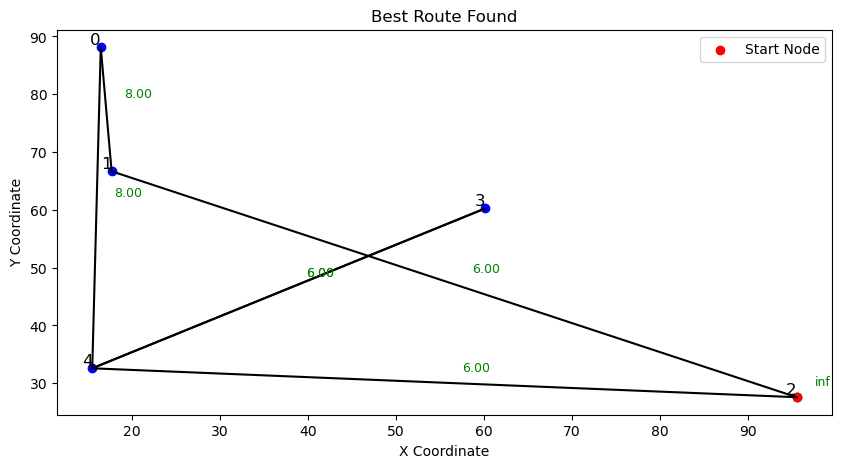

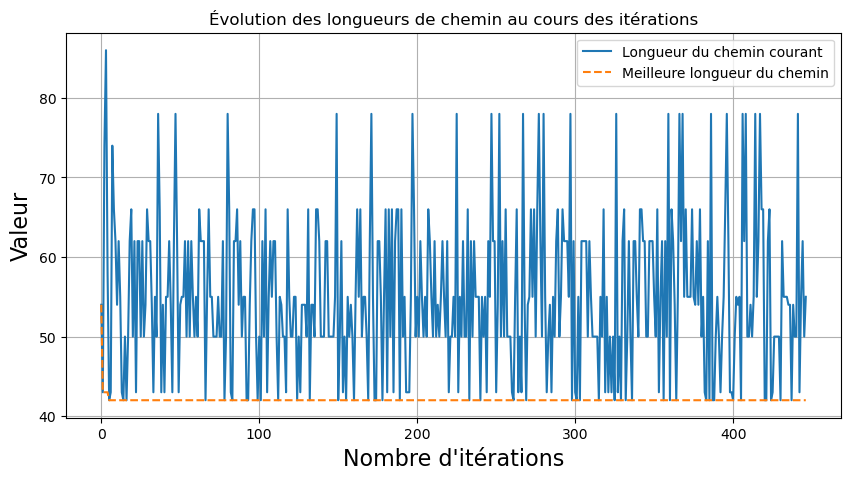

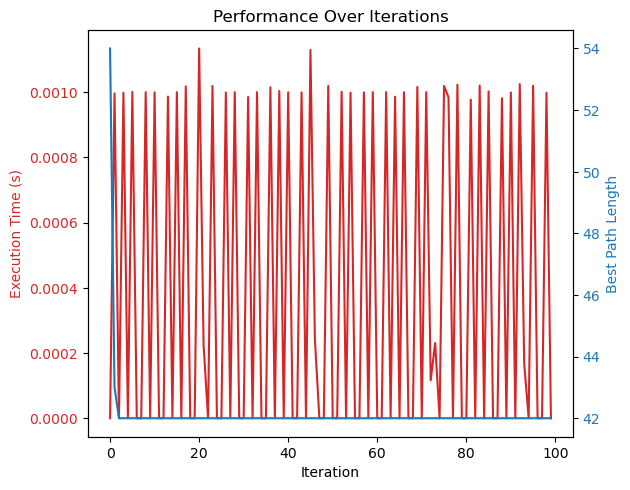

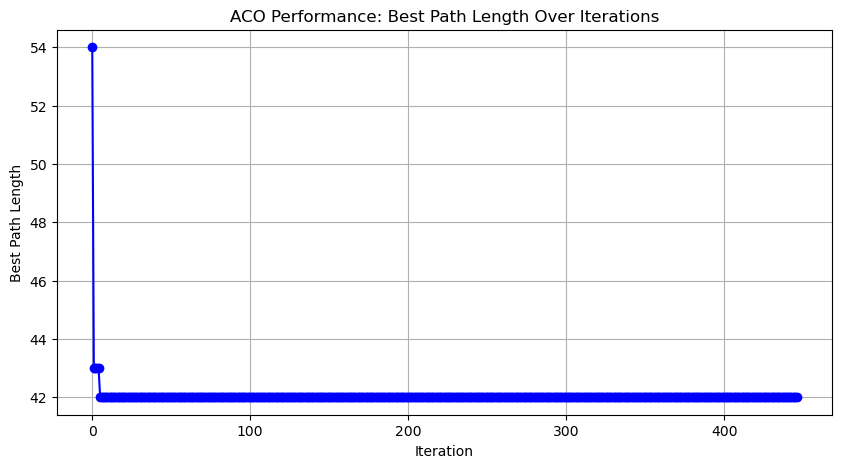

Meilleur chemin trouvé: 42.00


In [188]:
best_path, best_path_length, path_lengths, best_path_lengths , execution_times, distances = ant_colony_optimization()  
# Generate random points for plotting (for visualization purposes only)
points = np.random.rand(num_sommets, 2) * 100
print(f"Meilleur chemin trouvé : {best_path} avec une longueur de {best_path_length:.2f}")  
# Plot the best route
if best_path:
    plot_route(best_path, points, tsp_matrice)  
    plot_vi(path_lengths, best_path_lengths) 
# Plot the performance
plot_performance(execution_times, distances)  
plot_quality(best_path_lengths)  
print(f'Meilleur chemin trouvé: {best_path_length:.2f}')      

In [189]:
best_path_length, best_path = borne_inferieure(tsp_matrice)   
plot_routeLinear(best_path, points)    

No solution to plot.


In [190]:
# import random
# import statistics
# import numpy as np
# from collections import deque
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# # Example placeholder functions for the algorithm
# # These should be replaced by actual functions of the specific algorithm
# def generate_instance(nb_objets):
#     # Replace with actual instance generation logic
#     poids_objets = [random.randint(1, 10) for _ in range(nb_objets)]
#     valeur_objets = [random.randint(1, 10) for _ in range(nb_objets)]
#     return poids_objets, valeur_objets

# def calculate_upper_bound(poids_objets, valeur_objets):
#     # Replace with actual upper bound calculation logic
#     return sum(valeur_objets)

# def initial_solution(poids_objets, valeur_objets):
#     # Replace with actual solution generation logic
#     return [random.choice([0, 1]) for _ in range(len(poids_objets))]

# def search_algorithm(sac, taille_tabou, iter_max):
#     # Replace with actual search algorithm logic
#     return sac

# def solution_value(solution, valeur_objets):
#     # Replace with actual solution value calculation logic
#     return sum(valeur_objets[i] for i in range(len(solution)) if solution[i] == 1)

# # Main function to run the test
# def run_test(nb_objets, nb_test, iter_max, tabou_min, tabou_max):
#     random.seed(a=3)

#     # Setup progress bar
#     nb_steps_bar = (tabou_max - tabou_min) * nb_test
#     bar = tqdm(total=nb_steps_bar, desc="Progress", ncols=100)

#     # For storing results
#     moyennes = []
#     deviations = []

#     # Loop over the size of the tabu list
#     for taille_tabou in range(tabou_min, tabou_max):
#         bornes = deque()
#         for _ in range(nb_test):
#             # Generate instance and calculate upper bound
#             poids_objets, valeur_objets = generate_instance(nb_objets)
#             borne = calculate_upper_bound(poids_objets, valeur_objets)

#             # Get initial solution and run search algorithm
#             sac = initial_solution(poids_objets, valeur_objets)
#             sol = search_algorithm(sac, taille_tabou, iter_max)
#             val = solution_value(sol, valeur_objets)

#             # Update progress bar
#             bar.update(1)

#             # Calculate and store distance to upper bound
#             distance = val * 100 / borne
#             bornes.append(distance)

#         # Calculate mean and standard deviation for the current tabu list size
#         moyennes.append(statistics.fmean(bornes))
#         deviations.append(np.std(bornes))

#     # Close progress bar
#     bar.close()

#     # Plot the results
#     plt.plot(range(tabou_min, tabou_max), moyennes)
#     plt.fill_between(range(tabou_min, tabou_max),
#                      np.subtract(moyennes, deviations),
#                      np.add(moyennes, deviations),
#                      alpha=.1)
#     plt.xlabel("taille de la liste tabou")
#     plt.ylabel("distance à la borne")
#     plt.title("Impact de la taille de la liste tabou sur la qualité des solutions")
#     plt.show()

# # Parameters
# tabou_min = 1
# tabou_max = 20
# nb_objets = 200
# nb_test = 100
# iter_max = 20

# # Run the test
# run_test(nb_objets, nb_test, iter_max, tabou_min, tabou_max)

In [191]:
import numpy as np
import random
import time
import statistics 
from collections import deque
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Placeholder for the ACO algorithm parameters
num_sommets = 10
num_ants = 50
num_iterations = 100
alpha = 1.0
beta = 5.0
evaporation_rate = 0.5
pheromone_constant = 100.0

# Generating a random TSP instance
def generate_instance(num_sommets, max_poids_arete, max_intervalle_inf, max_intervalle_sup):
    matrice = np.full((num_sommets, num_sommets), np.inf)
    intervalles = {}

    for i in range(num_sommets):
        intervalle_start = random.randint(0, max_intervalle_inf)
        intervalle_end = intervalle_start + random.randint(max_intervalle_inf, max_intervalle_sup)
        intervalles[i] = (intervalle_start, intervalle_end)

    for i in range(num_sommets):
        for j in range(i + 1, num_sommets):
            if random.random() > 0.5:  # Adding some randomness to edge creation
                poids = random.randint(1, max_poids_arete)
                matrice[i][j] = poids
                matrice[j][i] = poids

    return matrice, intervalles

# Define the ACO algorithm functions

def is_edge_valid(from_node, to_node, current_length, visited, tsp_matrice, tsp_intervalles):
    weight = tsp_matrice[from_node][to_node]
    if weight == np.inf:
        return (False, 0)
    if to_node in visited:
        min_weight, max_weight = tsp_intervalles[to_node]
        if current_length + weight > max_weight:
            return (False, 0)
        if current_length + weight < min_weight:
            return (True,  min_weight - current_length)
    return (True, weight)

def update_pheromones(best_path, best_path_length, pheromone_tsp_matrice):
    pheromone_tsp_matrice *= (1 - evaporation_rate)
    for i in range(len(best_path) - 1):
        from_node = best_path[i]
        to_node = best_path[i + 1]
        pheromone_tsp_matrice[from_node][to_node] += pheromone_constant / best_path_length 

def select_next_node(current_node, visited, current_length, pheromone_tsp_matrice, tsp_matrice, tsp_intervalles):
    probabilities = []
    total_prob = 0
    pheromone_row = pheromone_tsp_matrice[current_node]
    heuristic_row = (1.0 / tsp_matrice[current_node]) ** beta

    for node in range(num_sommets):
        if node != current_node:
            valide, poids = is_edge_valid(current_node, node, current_length, visited, tsp_matrice, tsp_intervalles)
            if valide:
                pheromone_level = pheromone_row[node] ** alpha
                heuristic_level = heuristic_row[node]
                probability = pheromone_level * heuristic_level
                probabilities.append((node, probability))
                total_prob += probability
    
    if total_prob == 0:
        return (None, 0)
    
    threshold = random.uniform(0, total_prob)
    cumulative_prob = 0
    for node, probability in probabilities:
        cumulative_prob += probability
        if cumulative_prob >= threshold:
            valide, poids = is_edge_valid(current_node, node, current_length, visited, tsp_matrice, tsp_intervalles)
            return (node, poids)
    return (None, 0) 

def ant_colony_optimization(tsp_matrice, tsp_intervalles, num_ants, num_iterations):
    best_path = None
    best_path_length = float('inf') 
    path_lengths = deque()
    best_path_lengths = deque()
    execution_times = [] 
    distances = [] 
    pheromone_tsp_matrice = np.ones((num_sommets, num_sommets))

    for iteration in range(num_iterations):
        start_time = time.time() 
        all_paths = []
        for ant in range(num_ants):
            current_node = random.randint(0, num_sommets - 1)
            path = [current_node]
            visited = {current_node}
            min_weight, max_weight = tsp_intervalles[current_node]
            current_length = min_weight
            
            while len(visited) < num_sommets:
                next_node, weight_to_add = select_next_node(current_node, visited, current_length, pheromone_tsp_matrice, tsp_matrice, tsp_intervalles)
                if next_node is None:
                    break
                current_length += weight_to_add
                current_node = next_node
                path.append(current_node)
                visited.add(current_node)
            
            valid, weight = is_edge_valid(current_node, path[0], current_length, visited, tsp_matrice, tsp_intervalles)
            if len(visited) == num_sommets and valid:
                current_length += weight
                path_lengths.append(current_length)
                path.append(path[0]) 
                all_paths.append((path, current_length))
                if current_length < best_path_length:
                    best_path_length = current_length
                    best_path = path
                best_path_lengths.append(best_path_length)    
            
        if best_path:
            update_pheromones(best_path, best_path_length, pheromone_tsp_matrice)
        end_time = time.time()
        execution_times.append(end_time - start_time)
        distances.append(best_path_length) 
    
    return best_path, best_path_length, path_lengths, best_path_lengths, execution_times, distances

In [192]:
def calculate_upper_bound(poids_objets, valeur_objets):
    # Replace with actual upper bound calculation logic
    return sum(valeur_objets) 

In [193]:
# # Main function to run the test
# def run_test(nb_objets, nb_test, iter_max, tabou_min, tabou_max):
#     random.seed(a=3)

#     # Setup progress bar
#     nb_steps_bar = (tabou_max - tabou_min) * nb_test
#     bar = tqdm(total=nb_steps_bar, desc="Progress", ncols=100)

#     # For storing results
#     moyennes = []
#     deviations = []

#     # Loop over the size of the tabu list
#     for taille_tabou in range(tabou_min, tabou_max):
#         bornes = deque()
#         for _ in range(nb_test):
#             # Generate instance and calculate upper bound
#             tsp_matrice, tsp_intervalles = generate_instance(nb_objets, 10, 10, 20)
#             upper_bound = calculate_upper_bound(tsp_matrice, tsp_intervalles)

#             # Run ACO algorithm
#             best_path, best_path_length, path_lengths, best_path_lengths, execution_times, distances = ant_colony_optimization(tsp_matrice, tsp_intervalles, num_ants, iter_max)

#             # Update progress bar
#             bar.update(1)

#             # Calculate and store distance to upper bound
#             distance = best_path_length * 100 / upper_bound
#             bornes.append(distance)

#         # Calculate mean and standard deviation for the current tabu list size
#         moyennes.append(statistics.fmean(bornes))
#         deviations.append(np.std(bornes))

#     # Close progress bar
#     bar.close()

#     # Plot the results
#     plt.plot(range(tabou_min, tabou_max), moyennes)
#     plt.fill_between(range(tabou_min, tabou_max),
#                      np.subtract(moyennes, deviations),
#                      np.add(moyennes, deviations),
#                      alpha=.1)
#     plt.xlabel("taille de la liste tabou")
#     plt.ylabel("distance à la borne")
#     plt.title("Impact de la taille de la liste tabou sur la qualité des solutions")
#     plt.show()

# # Parameters
# tabou_min = 1
# tabou_max = 20
# nb_objets = 200
# nb_test = 100
# iter_max = 20

# # Run the test
# run_test(nb_objets, nb_test, iter_max, tabou_min, tabou_max)